# Import Library

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

# Import Dataset

In [2]:
pd.set_option('display.max_columns',33)

In [3]:
dfMetadata = pd.read_csv('movies_metadata.csv')
dfCredit = pd.read_csv('credits.csv')
dfKeyword = pd.read_csv('keywords.csv')
dfLinks = pd.read_csv('links_small.csv')
dfRating = pd.read_csv('ratings_small.csv')

## EDA

#### 1. dfMetadata

In [4]:
dfMetadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

In [5]:
dfMetadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
dfMetadata.shape

(45466, 24)

Ganti tipe data id menjadi int & drop yang id yang salah menjadi NaN

In [7]:
# dfMetadata['id'] = dfMetadata['id'].astype('int')
# Tidak bisa di astype ada data yang salah input / format
dfMetadata['id'] = pd.to_numeric(dfMetadata['id'], errors='coerce',downcast="integer")
# ‘coerce’ = invalid parsing menjadi NaN
dfMetadata.dropna(subset=['id'],inplace=True)
dfMetadata['id'] = dfMetadata['id'].astype('int')

In [8]:
dfMetadata.shape

(45463, 24)

#### 2. dfCredit

In [9]:
dfCredit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [10]:
dfCredit.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [11]:
dfMetadata.shape

(45463, 24)

In [12]:
dfMetadata = dfMetadata.merge(dfCredit, on=['id'])

In [13]:
dfMetadata.shape

(45538, 26)

#### 3. dfKeywords

In [14]:
dfKeyword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [15]:
dfKeyword.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [16]:
dfMetadata = dfMetadata.merge(dfKeyword, on=['id'])

In [17]:
dfMetadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [18]:
dfMetadata = dfMetadata.drop_duplicates()

In [19]:
dfMetadata.shape

(45462, 27)

#### 4. dfLinks

In [20]:
dfLinks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
imdbId     9125 non-null int64
tmdbId     9112 non-null float64
dtypes: float64(1), int64(2)
memory usage: 213.9 KB


In [21]:
dfLinks.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [22]:
# Buang tmbdId yang null
dfLinks = dfLinks[dfLinks['tmdbId'].notnull()]

In [23]:
# Ambil kolom tmdbId aja
dfLinks = dfLinks['tmdbId'].astype('int')

In [24]:
dfLinks.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

#### Cleaning Data

In [25]:
# Cek data yang null

In [26]:
dfMetadata.isnull().sum()

adult                        0
belongs_to_collection    40969
budget                       0
genres                       0
homepage                 37685
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   3
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      3
runtime                    260
spoken_languages             3
status                      84
tagline                  25050
title                        3
video                        3
vote_average                 3
vote_count                   3
cast                         0
crew                         0
keywords                     0
dtype: int64

In [27]:
# Kita perlu feature ['title',popularity','cast', 'crew', 'keywords'], maka yg null kita drop row nya
dfMetadata.dropna(subset=['title','popularity','cast', 'crew', 'keywords'], inplace=True)

In [28]:
dfMetadata.shape

(45459, 27)

In [29]:
# Karna ga kuat jadi pake data dari linksSmall aja
dfMetadata = dfMetadata[dfMetadata['id'].isin(dfLinks)]

In [30]:
dfMetadata.head()[['genres','cast','crew','keywords']]

,genres,cast,crew,keywords
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'id': 35, 'name': 'Comedy'}]","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


Perlu ambil genre, cast, crew (director), keywords

In [31]:
# Ambil genre lalu masukkan ke list
dfMetadata['genres'] = dfMetadata['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [32]:
dfMetadata.head()[['genres','cast','crew','keywords']]

,genres,cast,crew,keywords
0,"[Animation, Comedy, Family]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[Adventure, Fantasy, Family]","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[Romance, Comedy]","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[Comedy, Drama, Romance]","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,[Comedy],"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [33]:
dfMetadata['cast'] = dfMetadata['cast'].apply(literal_eval)
dfMetadata['crew'] = dfMetadata['crew'].apply(literal_eval)
dfMetadata['keywords'] = dfMetadata['keywords'].apply(literal_eval)

In [34]:
# Ambil 3 cast name dari kolom cast masukkan ke list
dfMetadata['cast'] = dfMetadata['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
dfMetadata['cast'] = dfMetadata['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [35]:
# Ambil 'director' dari kolom 'crew' , kl tdk ada maka return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [36]:
dfMetadata['director'] = dfMetadata['crew'].apply(get_director)


In [37]:
# Ambil keywords
dfMetadata['keywords'] = dfMetadata['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [38]:
dfMetadata.head()[['genres','cast','keywords','director']]

,genres,cast,keywords,director
0,"[Animation, Comedy, Family]","[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter
1,"[Adventure, Fantasy, Family]","[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston
2,"[Romance, Comedy]","[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch
3,"[Comedy, Drama, Romance]","[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",Forest Whitaker
4,[Comedy],"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer


In [39]:
# Bikin tabel baru isinya 'description' yg isinya overview + tagline
dfMetadata['tagline'] = dfMetadata['tagline'].fillna('')
dfMetadata['description'] = dfMetadata['overview'] + dfMetadata['tagline']
dfMetadata['description'] = dfMetadata['description'].fillna('')

In [40]:
dfMetadata[['description']].head()

,description
0,"Led by Woody, Andy's toys live happily in his ..."
1,When siblings Judy and Peter discover an encha...
2,A family wedding reignites the ancient feud be...
3,"Cheated on, mistreated and stepped on, the wom..."
4,Just when George Banks has recovered from his ...


In [41]:
# convert feature release_data menjadi year dengan mengambil year nya saja
dfMetadata['year'] = pd.to_datetime(dfMetadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [42]:
dfMetadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,description,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",Joe Johnston,When siblings Judy and Peter discover an encha...,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,A family wedding reignites the ancient feud be...,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",Forest Whitaker,"Cheated on, mistreated and stepped on, the wom...",1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer,Just when George Banks has recovered from his ...,1995


Drop columns yang tidak terpakai

In [43]:
dfMetadata.drop(['belongs_to_collection','homepage','original_title','video','imdb_id','release_date','budget','revenue','runtime','poster_path','production_companies','production_countries','revenue','spoken_languages', 'status','crew'], axis=1, inplace=True)

#### Plot & Graph

Text(0.5, 1.0, 'Rating Distribution')

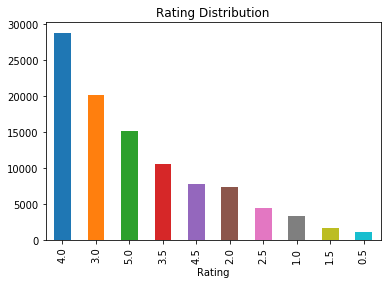

In [44]:
dfRating['rating'].value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.title('Rating Distribution')
# plt.savefig('rating.png')

In [45]:
dfRating['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

Text(0.5, 1.0, 'Movie Year Distribution')

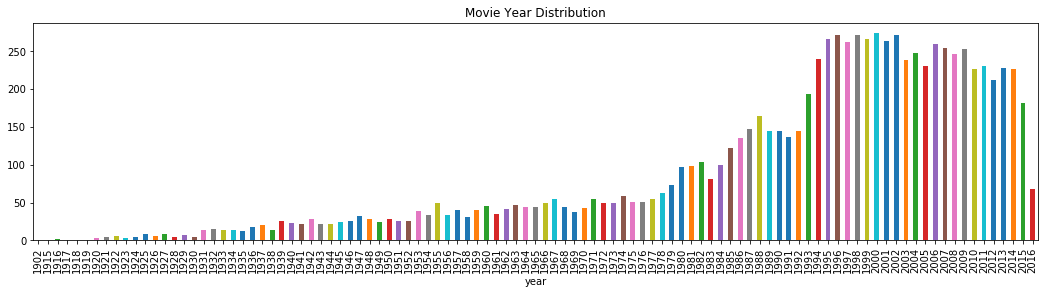

In [46]:
plt.figure(figsize=(18,4))
dfMetadata['year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('year')
plt.title('Movie Year Distribution')
# plt.savefig('year.png')

Text(0.5, 1.0, 'Adult Distribution')

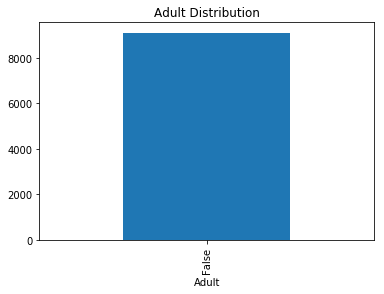

In [47]:
dfMetadata['adult'].value_counts().plot(kind='bar')
plt.xlabel('Adult')
plt.title('Adult Distribution')

Text(0.5, 1.0, 'Language Distribution')

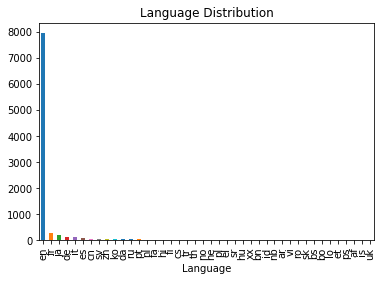

In [48]:
dfMetadata['original_language'].value_counts().plot(kind='bar')
plt.xlabel('Language')
plt.title('Language Distribution')

## 1. Simple Recommender System

Saya akan membuat 3 Simple Recommender System dari Filtering Dataset yang ada:
1. Top Movies Chart
2. Popular Movies
3. Top *GENRE* Movies

### 1. Top Movies Chart

Disini saya membuat TOP MOVIES CHART berdasarkan formula IMDB's Weighted Rating, yaitu :

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

* *v* jumlah votes per movie
* *m* syarat jumlah vote minimum agar movie masuk ke chart
* *R* rata-rata votes per movie
* *C* rata-rata votes semua movie

Untuk menentukan nilai 'm' saya menggunakan 95th percentile.
Yaitu, untuk movie bisa masuk ke chart setidaknya harus memiliki votes dari 95% daftar movie yang ada.

In [49]:
vote_counts = dfMetadata[dfMetadata['vote_count'].notnull()]['vote_count'].astype('int')
m = vote_counts.quantile(0.95)
m

2079.0499999999993

In [50]:
vote_averages = dfMetadata[dfMetadata['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.9157142857142855

In [51]:
dfTopChart = dfMetadata[(dfMetadata['vote_count'] >= m) & (dfMetadata['vote_count'].notnull()) & (dfMetadata['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

In [52]:
# Mengganti type data 'vote_count' & 'vote_average' mejadi int
dfTopChart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 40631
Data columns (total 6 columns):
title           455 non-null object
year            455 non-null object
vote_count      455 non-null float64
vote_average    455 non-null float64
popularity      455 non-null object
genres          455 non-null object
dtypes: float64(2), object(4)
memory usage: 24.9+ KB


In [53]:
dfTopChart['vote_average'] = dfTopChart['vote_average'].astype('int')
dfTopChart.shape

(455, 6)

Dari perhitungan diatas, dapat di simpulkan:
* m (syarat jumlah vote minimum) = 2079 votes
* R (rata-rata votes per movie) = 5.9 dari 10
* Jumlah movie yang masuk ke Top Chart = 455 movies

In [54]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [55]:
dfTopChart['weighted_rate'] = dfTopChart.apply(weighted_rating, axis=1)

In [56]:
# 10 Top Chart Movies di sort berdasarkan Weighted Rate
dfTopChart = dfTopChart.sort_values('weighted_rate', ascending=False)
dfTopChart.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rate
15651,Inception,2010,14075.0,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.731749
12589,The Dark Knight,2008,12269.0,8,123.167,"[Drama, Action, Crime, Thriller]",7.697984
23076,Interstellar,2014,11187.0,8,32.2135,"[Adventure, Drama, Science Fiction]",7.673352
2870,Fight Club,1999,9678.0,8,63.8696,[Drama],7.631427
4904,The Lord of the Rings: The Fellowship of the Ring,2001,8892.0,8,32.0707,"[Adventure, Fantasy, Action]",7.605021
292,Pulp Fiction,1994,8670.0,8,140.95,"[Thriller, Crime]",7.596864
314,The Shawshank Redemption,1994,8358.0,8,51.6454,"[Drama, Crime]",7.584812
7069,The Lord of the Rings: The Return of the King,2003,8226.0,8,29.3244,"[Adventure, Fantasy, Action]",7.579494
351,Forrest Gump,1994,8147.0,8,48.3072,"[Comedy, Drama, Romance]",7.576246
5876,The Lord of the Rings: The Two Towers,2002,7641.0,8,29.4235,"[Adventure, Fantasy, Action]",7.554186


In [57]:
dfTopChart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 15651 to 30766
Data columns (total 7 columns):
title            455 non-null object
year             455 non-null object
vote_count       455 non-null float64
vote_average     455 non-null int64
popularity       455 non-null object
genres           455 non-null object
weighted_rate    455 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.4+ KB


Text(0.5, 1.0, 'Top 10 Movies')

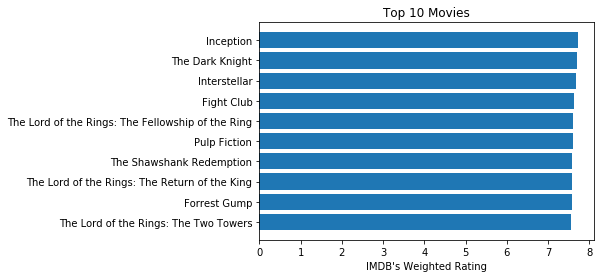

In [58]:
plt.barh(dfTopChart['title'].head(10), dfTopChart['weighted_rate'].head(10))
plt.gca().invert_yaxis()
plt.xlabel("IMDB's Weighted Rating")
plt.title('Top 10 Movies')

### 2. Popular Movies

In [59]:
# Ganti type menjadi float agar bisa di sort
dfTopChart['popularity'] = dfTopChart['popularity'].astype(float)

In [60]:
dfPopular = dfTopChart.sort_values('popularity',ascending=False)

In [61]:
# 10 Film terpopular berdasarkan kolom popularity
dfPopular.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rate
30910,Minions,2015,4729.0,6,547.488298,"[Family, Animation, Adventure, Comedy]",5.974261
24657,Big Hero 6,2014,6289.0,7,213.849907,"[Adventure, Family, Animation, Action, Comedy]",6.730608
26779,Deadpool,2016,11444.0,7,187.860492,"[Action, Adventure, Comedy]",6.833301
14723,Avatar,2009,12114.0,7,185.070892,"[Action, Adventure, Fantasy, Science Fiction]",6.841170
24553,John Wick,2014,5499.0,7,183.870374,"[Action, Thriller]",6.702524
23870,Gone Girl,2014,6023.0,7,154.801009,"[Mystery, Thriller, Drama]",6.721764
25074,The Hunger Games: Mockingjay - Part 1,2014,5767.0,6,147.098006,"[Science Fiction, Adventure, Thriller]",5.977666
26782,Captain America: Civil War,2016,7462.0,7,145.882135,"[Adventure, Action, Science Fiction]",6.763728
292,Pulp Fiction,1994,8670.0,8,140.950236,"[Thriller, Crime]",7.596864
12589,The Dark Knight,2008,12269.0,8,123.167259,"[Drama, Action, Crime, Thriller]",7.697984


Text(0.5, 1.0, 'Popular Movies')

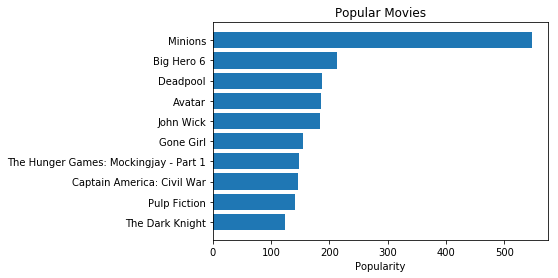

In [62]:
plt.barh(dfPopular['title'].head(10), dfPopular['popularity'].head(10))
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title('Popular Movies')

### 3. Top Movies Based on Genre

In [63]:
# Membuat series movie yang multiple genre menjadi Stack
s = dfMetadata.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [64]:
# Check genre apa saja yang ada
for i in s.unique():
    print(i)

Animation
Comedy
Family
Adventure
Fantasy
Romance
Drama
Action
Crime
Thriller
Horror
History
Science Fiction
Mystery
War
Foreign
Music
Documentary
Western
TV Movie


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

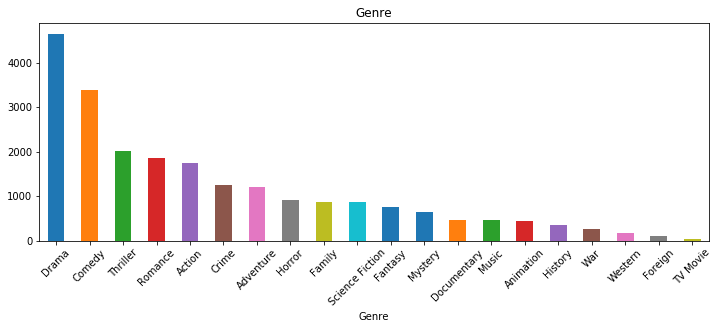

In [65]:
plt.figure(figsize=(12,4))
s.value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.title('Genre')
plt.xticks(rotation=45)
# plt.savefig('genre.png')

In [66]:
dfGenre = dfMetadata.drop('genres', axis=1).join(s)

In [67]:
dfGenre.head()

,adult,id,original_language,overview,popularity,tagline,title,vote_average,vote_count,cast,keywords,director,description,year,genre
0,False,862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995,Animation
0,False,862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995,Comedy
0,False,862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995,Family
1,False,8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,When siblings Judy and Peter discover an encha...,1995,Adventure
1,False,8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,When siblings Judy and Peter discover an encha...,1995,Fantasy


In [68]:
# dfGenre.to_csv("dfGenreStack.csv", encoding='utf-8', index=False)

In [69]:
def genreRecommender(genre, percentile=0.95):
    # Bikin DataFrame yg berisi genre yang di input
    print('TOP 10 {} Movies'.format(genre))
    df = dfGenre[dfGenre['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    # menggunakan rumus IMDB's weighte rating
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    # Sort berdasarkan Weighted Rating
    qualified = qualified.sort_values('wr', ascending=False)
    return qualified

In [70]:
favourite_genre = 'Animation'
# Sistem kan memberikan 10 rekomendasi movie berdasarkan genre
genreRecommender(favourite_genre).head(10)

TOP 10 Animation Movies


,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.6058,7.283814
5529,Spirited Away,2001,3968,8,41.0489,7.143741
13875,Up,2009,7048,7,19.3309,6.743323
30525,Inside Out,2015,6737,7,23.9856,6.735866
15643,Despicable Me,2010,6595,7,22.2745,6.732315
12812,WALL·E,2008,6439,7,16.0884,6.728302
6301,Finding Nemo,2003,6292,7,25.4978,6.724409
24657,Big Hero 6,2014,6289,7,213.85,6.724328
4797,"Monsters, Inc.",2001,6150,7,26.42,6.720541
22308,Frozen,2013,5440,7,24.2482,6.699449


In [71]:
favourite_genre = 'Science Fiction'

# Sistem kan memberikan 10 rekomendasi movie berdasarkan genre
genreRecommender(favourite_genre).head(10)

TOP 10 Science Fiction Movies


,title,year,vote_count,vote_average,popularity,wr
15651,Inception,2010,14075,8,29.1081,7.406222
23076,Interstellar,2014,11187,8,32.2135,7.298710
256,Star Wars,1977,6778,8,42.1497,7.030796
1246,Back to the Future,1985,6239,8,25.7785,6.983314
1175,The Empire Strikes Back,1980,5998,8,19.471,6.960544
14723,Avatar,2009,12114,7,185.071,6.619448
18008,The Avengers,2012,12000,7,89.8876,6.616860
23948,Guardians of the Galaxy,2014,10014,7,53.2916,6.565366
26768,Mad Max: Fury Road,2015,9629,7,29.3618,6.553739
2478,The Matrix,1999,9079,7,33.3663,6.536008


## 2. Content Based Filtering

Diatas merupakan simple recommender system di atas yang hanya berdasarkan GENRE. Dimana seseorang hanya di rekomendasikan movie yang berada di Top Chart yang berdasarkan GENRE yang di input. Recommender system tersebut hanya menggunakan 1 feature.

Untuk membuat recommender system yang lebih baik, maka saya akan menggunakan Content Based Recommender. Yaitu, recommender system yang akan memperhtiungkan similarity/kemiripan antar movie berdasarkan kemiripan movie yang pernah di like oleh user.

Saya akan membuat 2 Content Based Recomender System berdasarkan:
1. Description (Overview & Taglines)
2. Cast, Crew, Keywords, Genre

### 1. Recommender System Based on Description

In [72]:
# Sebelumnya saya sudah menggabungkan overview & taglines menjadi satu kolom description
dfMetadata[['description']].head()

,description
0,"Led by Woody, Andy's toys live happily in his ..."
1,When siblings Judy and Peter discover an encha...
2,A family wedding reignites the ancient feud be...
3,"Cheated on, mistreated and stepped on, the wom..."
4,Just when George Banks has recovered from his ...


In [73]:
# Cek null
dfMetadata[['description']].isnull().sum()

description    0
dtype: int64

#### TF-IDF Vectorizer

Menggunakan TF-IDF Vectorizer untuk memperhitungkan bobot tiap kata dan menghapus semua stopwords dalam bahasa inggris (contoh: a, the)


In [74]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(dfMetadata['description'])

In [75]:
tfidf_matrix.shape

(9100, 268124)

#### Cosine Similarity
Metode cosine similarity merupakan metode untuk menghitung jumlah kesamaan antara dua movies, yang dinyatakan dalam dua buah vector dengan menggunakan keywords (kata kunci) dari sebuah dokumen sebagai ukuran. 

Karena saya menggunakan TF-IDF Vectorizer, maka saya akan menggunakan linear_kernel dari sklearn untuk menghitung Cosine Similarity Score

In [76]:
# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [77]:
# Lihat isi Cosine_sim
cosine_sim

array([[1.        , 0.00680483, 0.        , ..., 0.        , 0.        ,
        0.00477958],
       [0.00680483, 1.        , 0.01531037, ..., 0.        , 0.0017496 ,
        0.00366926],
       [0.        , 0.01531037, 1.        , ..., 0.00192747, 0.00220611,
        0.        ],
       ...,
       [0.        , 0.        , 0.00192747, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.0017496 , 0.00220611, ..., 0.        , 1.        ,
        0.00146179],
       [0.00477958, 0.00366926, 0.        , ..., 0.        , 0.00146179,
        1.        ]])

Saya sudah memiliki Cosine Similarity Matrix dari semua movie dari dataset. Sekarang saya akan membuat function yang me-return movies yang berdasarkan Cosine Similarity Score

In [78]:
# Membuat indices = index movie title & id movie
dfMetadata = dfMetadata.reset_index()

In [79]:
titles = dfMetadata['title']
indices = pd.Series(dfMetadata.index, index=titles)

In [80]:
indices[:6]

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
Heat                           5
dtype: int64

In [81]:
def content_recommender(title):
    # Get the index of the movie that matches the title
    idx = indices[title]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:31]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return titles.iloc[movie_indices]

Coba rekomendasi dan ambil 10 data teratas

In [82]:
content_recommender('Batman Returns').head(10)

7578                 Batman: Under the Red Hood
7943                      The Dark Knight Rises
8239    Batman: The Dark Knight Returns, Part 2
2582               Batman: Mask of the Phantasm
6914                            The Dark Knight
132                              Batman Forever
8177    Batman: The Dark Knight Returns, Part 1
916                          The Wrong Trousers
6157                              Batman Begins
7913                           Batman: Year One
Name: title, dtype: object

In [83]:
content_recommender('Star Wars').head(10)

953                          The Empire Strikes Back
966                               Return of the Jedi
8764                    Star Wars: The Force Awakens
6704                                 Shrek the Third
6138    Star Wars: Episode III - Revenge of the Sith
4827                               Where Eagles Dare
7552                             Shrek Forever After
2899                 On Her Majesty's Secret Service
5817                                 The Ice Pirates
515                                 Princess Caraboo
Name: title, dtype: object

Dari hasil recommender system kedua diatas, dapat dilihat dari contoh:
* BATMAN RETURNS, system sudah bisa mendeteksi bahwa The Dark Knight Rises merupakan film batman, dan 
* STAR WARS system sudah bisa memberikan rekomendasi seperti The Empire Strikes Back dan Return of the Jedi.

Namun, untuk membuat recommender system ini semakin robust, maka saya akan menambahkan feature tambahan,
Karena mungkin saja user yang menyukai film The Dark Knight juga menyukai film oleh Christopher Nolan, dimana recommender system ini belum memberikan rekomendasi berikut

### 2. Recommender System Based on Movie Metadata

In [84]:
# Cek feature tambahan yg sebelumnya sudah kita cleaning
dfMetadata[['cast','director','genres','keywords']].head()

,cast,director,genres,keywords
0,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva..."
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'..."
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o..."
3,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker,"[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin..."
4,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,[Comedy],"[baby, midlife crisis, confidence, aging, daug..."


Untuk membedakan nama tiap cast, maka saya akan me-lower dan menghilangkan spasi nama cast



In [85]:
dfMetadata['cast'] = dfMetadata['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [86]:
dfMetadata['cast'][:6]

0                  [tomhanks, timallen, donrickles]
1       [robinwilliams, jonathanhyde, kirstendunst]
2          [waltermatthau, jacklemmon, ann-margret]
3    [whitneyhouston, angelabassett, lorettadevine]
4           [stevemartin, dianekeaton, martinshort]
5               [alpacino, robertdeniro, valkilmer]
Name: cast, dtype: object

Lalu untuk membuat nama director menjadi lebih dominan untuk tiap movie, maka saya akan membuat nama director menjadi 3x

In [87]:
# DIRECTOR X 3
dfMetadata['director'] = dfMetadata['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
dfMetadata['director'] = dfMetadata['director'].apply(lambda x: [x,x, x])

In [88]:
dfMetadata['director'][:6]

0          [johnlasseter, johnlasseter, johnlasseter]
1             [joejohnston, joejohnston, joejohnston]
2          [howarddeutch, howarddeutch, howarddeutch]
3    [forestwhitaker, forestwhitaker, forestwhitaker]
4          [charlesshyer, charlesshyer, charlesshyer]
5             [michaelmann, michaelmann, michaelmann]
Name: director, dtype: object

Cek keyword yang ada di dataset

In [89]:
s = dfMetadata.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [90]:
s = s.value_counts()

In [91]:
s[:5]

independent film        603
woman director          541
murder                  397
duringcreditsstinger    327
based on novel          312
Name: keyword, dtype: int64

Saya akan membuang keyword yang hanya muncul 1x

In [92]:
s = s[s > 1]

Lalu menggunakan SnowballStemer untuk meng convert setiap keyword menjadi kata dasar. Contoh : (Dogs menjadi Dog, Having menjadi Have, Generously menjadi Generous)

In [93]:
stemmer = SnowballStemmer('english')
# Tes stemmer
stemmer.stem('generously')

'generous'

Saya membuat feature baru 'keys' yg berisi kombinasi dari keywords, cast, director, dan genre. Lalu digabungkan dan dipishakan berdasarkan spasi

In [94]:
dfMetadata['keys'] = dfMetadata['keywords'] + dfMetadata['cast'] + dfMetadata['director'] + dfMetadata['genres']
dfMetadata['keys'] = dfMetadata['keys'].apply(lambda x: ' '.join(x))

In [95]:
dfMetadata[['keys']].head()

,keys
0,jealousy toy boy friendship friends rivalry bo...
1,board game disappearance based on children's b...
2,fishing best friend duringcreditsstinger old m...
3,based on novel interracial relationship single...
4,baby midlife crisis confidence aging daughter ...


Menggunakan CountVectorizer yang dapat mengubah fitur teks menjadi sebuah representasi vector.

In [96]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(dfMetadata['keys'])

In [97]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [98]:
cosine_sim

array([[1.        , 0.03798001, 0.02140293, ..., 0.        , 0.        ,
        0.        ],
       [0.03798001, 1.        , 0.        , ..., 0.02708645, 0.04255319,
        0.        ],
       [0.02140293, 0.        , 1.        , ..., 0.03052813, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02708645, 0.03052813, ..., 1.        , 0.08125935,
        0.        ],
       [0.        , 0.04255319, 0.        , ..., 0.08125935, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [99]:
# np.save('cosine', cosine_sim)

In [100]:
dfMetadata = dfMetadata.reset_index()
titles = dfMetadata['title']
indices = pd.Series(dfMetadata.index, index=dfMetadata['title'])

In [101]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
Heat                                                     5
Sabrina                                                  6
Tom and Huck                                             7
Sudden Death                                             8
GoldenEye                                                9
The American President                                  10
Dracula: Dead and Loving It                             11
Balto                                                   12
Nixon                                                   13
Cutthroat Island                                        14
Casino                                                  15
Sense and Sensibility                             

Kita tes fungsi content_recommender menggunakan cosine_sim yang baru

In [102]:
content_recommender('Batman Returns').head(10)

524                      Batman
1243             Batman & Robin
6914            The Dark Knight
6157              Batman Begins
7473        Alice in Wonderland
2475              Sleepy Hollow
8741                   Big Eyes
1813        Edward Scissorhands
6113                    Vincent
2878    Pee-wee's Big Adventure
Name: title, dtype: object

In [103]:
content_recommender('The Prestige').head(10)

4112                 Insomnia
3364                  Memento
2068                Following
7943    The Dark Knight Rises
7567                Inception
6914          The Dark Knight
6157            Batman Begins
8518             Interstellar
6661              Premonition
1006                Chinatown
Name: title, dtype: object

Hasilnya semakin baik, seperti rekomendasi yang diberikan dari film 'The Prestige', system sudah bisa merekomendasikan film Inception & Interstellar yaitu film dari Christopher Nolan

Sekarang kita akan melakukan peningkatan kemampuan dari system recommender kita:

In [104]:
def improved_recommender(title):
    # Ambil index dari movie title
    idx = indices[title]
    # Menghitung similarity score dari semua movie terhadap movie title tersebut
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort movies berdasarkan similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Ambil similarity score dari 25 movie yang mirip, mulai dari index 1 karna index 0 = film sendiri (sangat similiar)
    sim_scores = sim_scores[1:26]
    # Mendapatkan index movie nya
    movie_indices = [i[0] for i in sim_scores]
    
    # IMDB's weighted review
    movies = dfMetadata.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    # Sort movies berdasarkan weighted rating
    qualified = qualified.sort_values('wr', ascending=False)
    return qualified.head(10)

In [105]:
improved_recommender('Batman Returns')

,title,vote_count,vote_average,year,wr
6914,The Dark Knight,12269,8,2008,7.697984
7943,The Dark Knight Rises,9263,7,2012,6.801245
6157,Batman Begins,7511,7,2005,6.764935
1813,Edward Scissorhands,3731,7,1990,6.612003
524,Batman,2145,7,1989,6.466322
5026,Big Fish,2064,7,2003,6.455888
7473,Alice in Wonderland,4773,6,2010,5.974426
5987,Charlie and the Chocolate Factory,3759,6,2005,5.969984
8035,Dark Shadows,2383,5,2012,5.426668
8923,Batman v Superman: Dawn of Justice,7189,5,2016,5.205417


In [106]:
improved_recommender('Interstellar')

,title,vote_count,vote_average,year,wr
7567,Inception,14075,8,2010,7.731749
7215,Star Trek,4574,7,2009,6.661165
745,2001: A Space Odyssey,3075,7,1968,6.562619
8382,About Time,2140,7,2013,6.465689
7895,Real Steel,2749,6,2011,5.963705
1480,Armageddon,2540,6,1998,5.962063
8835,Midnight Special,705,6,2016,5.937058
4364,Solaris,378,5,2002,5.774838
3647,Planet of the Apes,1270,5,2001,5.568464
8753,Terminator Genisys,3677,5,2015,5.330750


Dari hasil ini, dapat di lihat bahwa Content Based  Recommender System diatas sudah cukup baik dalam memberikan rekomendasi film. 
Namun, Content Based hanya melakukan rekomendasi berdasarkan kemiripan film.

## 3. Collaborative Filtering

Selanjutnya, saya akan membuat Collaborative Filtering Recommender System, yaitu recommender system yang menggunakan Item-based : menghitung kemiripan antara movie yang di rating dengan movie lainnya.

Karna juga memperhitungkan history user, sehingga hasil rekomendasi yang diberikan lebih akurat dan sesuai dengan user.

Saya akan menggunakan SVD untuk mendapatkan kemiripan antar user dan item(movie), yaitu dengan melakukan prediksi rating yang akan di berikan user terhadap movie di dataset. 

In [107]:
reader = Reader()
data = Dataset.load_from_df(dfRating[['userId', 'movieId', 'rating']], reader)
# Train data 5 folds
data.split(n_folds=5)

In [108]:
svd = SVD()
evaluate(svd, data, measures=['RMSE'])

Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8892
------------
Fold 2
RMSE: 0.9051
------------
Fold 3
RMSE: 0.9057
------------
Fold 4
RMSE: 0.8913
------------
Fold 5
RMSE: 0.8925
------------
------------
Mean RMSE: 0.8968
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8891743624799129,
                             0.9050915760048697,
                             0.9056858494579783,
                             0.891342903197469,
                             0.8925483742480096]})

Untuk melihat apakan prediksi rating yg diberikan sudah baik, dapat menggunakan RMSE (Root Mean Square Error) dimana semakin rendah RMSE makan semakin bagus. Namun, karena kita tidak memiliki data rating untuk movie yang belum pernah di rating, maka hanya dapat meminimalisir RMSE dengan menggunakan Singular Value Decomposition (SVD).

Kita mendapatkan Rata-rata RMSE : 0.8966

Train dataset tanpa split untuk memberikan hasil yang terbaik

In [109]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [110]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]

In [111]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [112]:
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(dfMetadata[['title', 'id']], on='id').set_index('title')

In [113]:
id_map.head()

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0


In [114]:
# id_map.to_csv("id_map.csv", encoding='utf-8', index='title')

In [115]:
def final_recommender(userId, title):
    # Ambil index dari movie title
    idx = indices[title]
    # Cek tmdbId
    tmdbId = id_map.loc[title]['id']
    # Cek movieId
    movie_id = id_map.loc[title]['movieId']
#     print('movieid: ')
#     print(movie_id)
    # Menghitung similarity score dari semua movie terhadap movie title tersebut
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    # Sort movies berdasarkan similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Ambil similarity score dari 25 movie yang mirip, mulai dari index 1 karna index 0 = film sendiri (sangat similiar)
    sim_scores = sim_scores[1:26]
#     print('sim : ')
#     print(sim_scores)
    # Mendapatkan index movie nya
    movie_indices = [i[0] for i in sim_scores]
    # Buat DataFrame dari id movie_indices
    movies = dfMetadata.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    # Hitung SVD.est simpan di column 'est' lalu di sort
    
#     a = svd.predict(1, id_map[id_map['id'] == 811]['movieId'][0]).est
#     movies['est'] = movies['id'].apply(lambda x : id_map[id_map['id'] == x])
    
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, id_map[id_map['id'] == x]['movieId'][0]).est)
    
    # Sort est / prediksi rating
    movies = movies.sort_values('est', ascending=False)
    # Return the top 10 most similar movies
    return movies.head(10)

In [116]:
final_recommender(1, 'Interstellar')

,title,vote_count,vote_average,year,id,est
8382,About Time,2140.0,7.8,2013,122906,3.120370
7567,Inception,14075.0,8.1,2010,27205,3.041096
7215,Star Trek,4574.0,7.4,2009,13475,2.930816
5449,Dear Frankie,48.0,7.1,2004,8981,2.918647
2691,The Big Country,70.0,7.8,1958,12501,2.873563
3792,Mission to Mir,2.0,3.0,1997,15560,2.838688
2416,Last Night,41.0,7.0,1998,16129,2.803362
5242,Babylon 5: A Call to Arms,36.0,6.9,1999,10916,2.798380
745,2001: A Space Odyssey,3075.0,7.9,1968,62,2.795159
6255,Star Wreck: In the Pirkinning,27.0,6.6,2005,15493,2.740425


In [117]:
# def svdmap():
#     movid = []
#     for x in tes['id']:
#         movid.append(id_map[id_map['id'] == x]['movieId'].iloc[0])
#     estsvd = []
#     for a in movid:
#         estsvd.append(svd.predict(1,a).est)
#     return movid

In [118]:
# svdmap()

In [119]:
# tes['a'] = svdmap()

In [120]:
# tes

In [121]:
final_recommender(1, 'Interstellar')

,title,vote_count,vote_average,year,id,est
8382,About Time,2140.0,7.8,2013,122906,3.120370
7567,Inception,14075.0,8.1,2010,27205,3.041096
7215,Star Trek,4574.0,7.4,2009,13475,2.930816
5449,Dear Frankie,48.0,7.1,2004,8981,2.918647
2691,The Big Country,70.0,7.8,1958,12501,2.873563
3792,Mission to Mir,2.0,3.0,1997,15560,2.838688
2416,Last Night,41.0,7.0,1998,16129,2.803362
5242,Babylon 5: A Call to Arms,36.0,6.9,1999,10916,2.798380
745,2001: A Space Odyssey,3075.0,7.9,1968,62,2.795159
6255,Star Wreck: In the Pirkinning,27.0,6.6,2005,15493,2.740425


In [122]:
final_recommender(999, 'Interstellar')

,title,vote_count,vote_average,year,id,est
8382,About Time,2140.0,7.8,2013,122906,4.025515
7567,Inception,14075.0,8.1,2010,27205,3.972978
745,2001: A Space Odyssey,3075.0,7.9,1968,62,3.858842
7215,Star Trek,4574.0,7.4,2009,13475,3.802251
2691,The Big Country,70.0,7.8,1958,12501,3.728792
5449,Dear Frankie,48.0,7.1,2004,8981,3.654352
3792,Mission to Mir,2.0,3.0,1997,15560,3.606664
5242,Babylon 5: A Call to Arms,36.0,6.9,1999,10916,3.604544
6843,The Savages,112.0,6.8,2007,8272,3.591572
5384,Jamon Jamon,60.0,6.2,1992,4507,3.583608


Dari hasil final recommender system diatas, dapat dilihat bahwa system dapat memberikan rekomendasi movie yang berbeda untuk user yang berbeda, hal ini karena system juga memperhitungkan history user. 
Jika dibandingkan dengan system recommender yang pertama, tentu hasil recommender system yang final ini dapat memberikan hasil yang jauh lebih baik dan sesuai dengan user.

# RECOMMENDER SYSTEM - GLEN PUTRA WANGSA 2019

In [123]:
# dfMetadata.to_csv("dfMovies.csv", encoding='utf-8', index=False)

In [124]:
dfMetadata.head()

,level_0,index,adult,genres,id,original_language,overview,popularity,tagline,title,vote_average,vote_count,cast,keywords,director,description,year,keys
0,0,0,False,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy, friendship, friends, riva...","[johnlasseter, johnlasseter, johnlasseter]","Led by Woody, Andy's toys live happily in his ...",1995,jealousy toy boy friendship friends rivalry bo...
1,1,1,False,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[board game, disappearance, based on children'...","[joejohnston, joejohnston, joejohnston]",When siblings Judy and Peter discover an encha...,1995,board game disappearance based on children's b...
2,2,2,False,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[fishing, best friend, duringcreditsstinger, o...","[howarddeutch, howarddeutch, howarddeutch]",A family wedding reignites the ancient feud be...,1995,fishing best friend duringcreditsstinger old m...
3,3,3,False,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.85949,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[based on novel, interracial relationship, sin...","[forestwhitaker, forestwhitaker, forestwhitaker]","Cheated on, mistreated and stepped on, the wom...",1995,based on novel interracial relationship single...
4,4,4,False,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.38752,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[baby, midlife crisis, confidence, aging, daug...","[charlesshyer, charlesshyer, charlesshyer]",Just when George Banks has recovered from his ...,1995,baby midlife crisis confidence aging daughter ...


In [125]:
# [i for i in dfMetadata['year'].sort_values().unique()]

In [126]:
# newUserMovie = []
# tit = ['Forrest Gump', 'Deadpool', 'The Hangover', 'The Intouchables','Life Is Beautiful','The Wolf of Wall Street']
# for t in tit:
#     newUserMovie.append(id_map.loc[t]['movieId'])
# rating = [5,5,5,5,5,5]

In [127]:
# favourite_genre = 'Comedy'
# # Sistem kan memberikan 10 rekomendasi movie berdasarkan genre
# genreRecommender(favourite_genre).head(10)

In [128]:
# items = {
#     'userId' : [999,999,999,999,999,999],
#     'movieId' : [i for i in newUserMovie],
#     'rating' : [i for i in rating],
# }

# dfNewUser = pd.DataFrame(items)
# dfNewUser

In [129]:
# dfRating.append(dfNewUser)

In [130]:
# reader = Reader()
# data = Dataset.load_from_df(dfNewUser[['userId', 'movieId', 'rating']], reader)
# data.split(n_folds=5)

In [131]:
# svd = SVD()
# evaluate(svd, data, measures=['RMSE'])

In [132]:
# trainset = data.build_full_trainset()
# svd.train(trainset)

In [133]:
final_recommender(1, 'The Prestige')

,title,vote_count,vote_average,year,id,est
6914,The Dark Knight,12269.0,8.3,2008,155,3.484020
3364,Memento,4168.0,8.1,2000,77,3.481032
1006,Chinatown,939.0,7.9,1974,829,3.356947
8518,Interstellar,11187.0,8.1,2014,157336,3.258644
6157,Batman Begins,7511.0,7.5,2005,272,3.050495
7567,Inception,14075.0,8.1,2010,27205,3.041096
4944,Battle Royale,992.0,7.3,2000,3176,2.923436
7498,About Elly,98.0,7.3,2009,37181,2.836138
2658,Deterrence,7.0,6.1,2000,25212,2.819400
751,Spellbound,166.0,7.3,1945,4174,2.808109


In [134]:
final_recommender(2, 'The Prestige')

,title,vote_count,vote_average,year,id,est
1006,Chinatown,939.0,7.9,1974,829,4.377965
6914,The Dark Knight,12269.0,8.3,2008,155,4.124681
3364,Memento,4168.0,8.1,2000,77,4.097758
8518,Interstellar,11187.0,8.1,2014,157336,4.032478
4944,Battle Royale,992.0,7.3,2000,3176,3.941180
751,Spellbound,166.0,7.3,1945,4174,3.710860
7567,Inception,14075.0,8.1,2010,27205,3.708622
7498,About Elly,98.0,7.3,2009,37181,3.669156
6157,Batman Begins,7511.0,7.5,2005,272,3.650881
2068,Following,363.0,7.2,1998,11660,3.570090


In [135]:
dfMetadata.head()

,level_0,index,adult,genres,id,original_language,overview,popularity,tagline,title,vote_average,vote_count,cast,keywords,director,description,year,keys
0,0,0,False,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy, friendship, friends, riva...","[johnlasseter, johnlasseter, johnlasseter]","Led by Woody, Andy's toys live happily in his ...",1995,jealousy toy boy friendship friends rivalry bo...
1,1,1,False,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[board game, disappearance, based on children'...","[joejohnston, joejohnston, joejohnston]",When siblings Judy and Peter discover an encha...,1995,board game disappearance based on children's b...
2,2,2,False,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[fishing, best friend, duringcreditsstinger, o...","[howarddeutch, howarddeutch, howarddeutch]",A family wedding reignites the ancient feud be...,1995,fishing best friend duringcreditsstinger old m...
3,3,3,False,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.85949,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[based on novel, interracial relationship, sin...","[forestwhitaker, forestwhitaker, forestwhitaker]","Cheated on, mistreated and stepped on, the wom...",1995,based on novel interracial relationship single...
4,4,4,False,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.38752,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[baby, midlife crisis, confidence, aging, daug...","[charlesshyer, charlesshyer, charlesshyer]",Just when George Banks has recovered from his ...,1995,baby midlife crisis confidence aging daughter ...


In [136]:
# s = dfMetadata.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
# s.name = 'genre'

In [137]:
# dfMetadata['test'] = dfMetadata['genres'].apply(lambda x: ','.join(map(str, x)))

In [138]:
# dfMetadata.head()

In [139]:
dfMdTable = dfMetadata[['title','genres','year','cast','director','vote_average','vote_count','popularity','adult','original_language','overview']]

In [140]:
dfMdTable.columns = ['Title','Genres','Year','Cast','Director','Rating','RatingCount','Popularity','Adult','Language','Overview'] 

In [141]:
dfMdTable.head()

,Title,Genres,Year,Cast,Director,Rating,RatingCount,Popularity,Adult,Language,Overview
0,Toy Story,"[Animation, Comedy, Family]",1995,"[tomhanks, timallen, donrickles]","[johnlasseter, johnlasseter, johnlasseter]",7.7,5415.0,21.9469,False,en,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"[Adventure, Fantasy, Family]",1995,"[robinwilliams, jonathanhyde, kirstendunst]","[joejohnston, joejohnston, joejohnston]",6.9,2413.0,17.0155,False,en,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"[Romance, Comedy]",1995,"[waltermatthau, jacklemmon, ann-margret]","[howarddeutch, howarddeutch, howarddeutch]",6.5,92.0,11.7129,False,en,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,"[whitneyhouston, angelabassett, lorettadevine]","[forestwhitaker, forestwhitaker, forestwhitaker]",6.1,34.0,3.85949,False,en,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,[Comedy],1995,"[stevemartin, dianekeaton, martinshort]","[charlesshyer, charlesshyer, charlesshyer]",5.7,173.0,8.38752,False,en,Just when George Banks has recovered from his ...


In [142]:
dfMdTable['Genres'] = dfMdTable['Genres'].apply(lambda x: ' ,'.join(map(str, x)))
dfMdTable['Cast'] = dfMdTable['Cast'].apply(lambda x: ' ,'.join(map(str, x)))
dfMdTable['Director'] = dfMdTable['Director'].apply(lambda x: x[0])

In [143]:
dfMdTable.head()

,Title,Genres,Year,Cast,Director,Rating,RatingCount,Popularity,Adult,Language,Overview
0,Toy Story,"Animation ,Comedy ,Family",1995,"tomhanks ,timallen ,donrickles",johnlasseter,7.7,5415.0,21.9469,False,en,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"Adventure ,Fantasy ,Family",1995,"robinwilliams ,jonathanhyde ,kirstendunst",joejohnston,6.9,2413.0,17.0155,False,en,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"Romance ,Comedy",1995,"waltermatthau ,jacklemmon ,ann-margret",howarddeutch,6.5,92.0,11.7129,False,en,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Comedy ,Drama ,Romance",1995,"whitneyhouston ,angelabassett ,lorettadevine",forestwhitaker,6.1,34.0,3.85949,False,en,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Comedy,1995,"stevemartin ,dianekeaton ,martinshort",charlesshyer,5.7,173.0,8.38752,False,en,Just when George Banks has recovered from his ...


In [144]:
dfMdTable[dfMdTable['Cast'].str.contains(str.lower('Johnny Depp').replace(' ', ''))]

,Title,Genres,Year,Cast,Director,Rating,RatingCount,Popularity,Adult,Language,Overview
83,Nick of Time,"Crime ,Drama ,Thriller",1995,"johnnydepp ,courtneychase ,charless.dutton",johnbadham,6.1,190.0,6.84859,False,en,Gene Watson is a public accountant who arrives...
197,Don Juan DeMarco,"Romance ,Drama ,Comedy",1994,"johnnydepp ,marlonbrando ,fayedunaway",jeremyleven,6.3,184.0,7.43893,False,en,John Arnold DeMarco is a man who believes he i...
207,Ed Wood,"Comedy ,Drama ,History",1994,"johnnydepp ,martinlandau ,sarahjessicaparker",timburton,7.3,639.0,11.7204,False,en,"The mostly true story of the legendary ""worst ..."
302,What's Eating Gilbert Grape,"Romance ,Drama",1993,"johnnydepp ,leonardodicaprio ,juliettelewis",lassehallström,7.5,943.0,10.3919,False,en,Gilbert has to care for his brother Arnie and ...
603,Dead Man,"Drama ,Fantasy ,Western",1995,"johnnydepp ,garyfarmer ,crispinglover",jimjarmusch,7.2,397.0,6.50527,False,en,"On the run after murdering a man, accountant W..."
1167,Benny & Joon,"Comedy ,Drama ,Romance",1993,"johnnydepp ,marystuartmasterson ,aidanquinn",jeremiahs.chechik,6.9,220.0,10.5971,False,en,A mentally ill young woman finds her love in a...
1187,Donnie Brasco,"Crime ,Drama ,Thriller",1997,"johnnydepp ,alpacino ,michaelmadsen",mikenewell,7.4,1175.0,12.202,False,en,An FBI undercover agent infilitrates the mob a...
1455,Fear and Loathing in Las Vegas,"Adventure ,Drama ,Comedy",1998,"johnnydepp ,beniciodeltoro ,tobeymaguire",terrygilliam,7.2,1321.0,9.22035,False,en,The hallucinogenic misadventures of sportswrit...
1813,Edward Scissorhands,"Fantasy ,Drama ,Romance",1990,"johnnydepp ,winonaryder ,diannewiest",timburton,7.5,3731.0,17.6122,False,en,A small suburban town receives a visit from a ...
2264,The Astronaut's Wife,"Drama ,Science Fiction ,Thriller",1999,"johnnydepp ,charlizetheron ,joemorton",randravich,5.5,263.0,14.7059,False,en,When astronaut Spencer Armacost returns to Ear...


In [145]:
# dfMdTable.to_csv("dfTable.csv", encoding='utf-8', index=False)

In [146]:
# dfMdTable['Title'].sort_values()

In [147]:
# ['All','Animation','Comedy','Family','Adventure','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','History','Science Fiction','Mystery','War','Foreign','Music','Documentary','Western','TV Movie']

In [148]:
# ['All','2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009','2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001','2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993','1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985','1984', '1983', '1982', '1981', '1980', '1979', '1978', '1977','1976', '1975', '1974', '1973', '1972', '1971', '1970', '1969','1968', '1967', '1966', '1965', '1964', '1963', '1962', '1961','1960', '1959', '1958', '1957', '1956', '1955', '1954', '1953','1952', '1951', '1950', '1949', '1948', '1947', '1946', '1945','1944', '1943', '1942', '1941', '1940', '1939', '1938', '1937','1936', '1935', '1934', '1933', '1932', '1931', '1930', '1929','1928', '1927', '1926', '1925', '1924', '1923', '1922', '1921','1920', '1919', '1918', '1917', '1916', '1915', '1902']

In [149]:
dfMdTable[dfMdTable['Title'].str.contains('Action')]

,Title,Genres,Year,Cast,Director,Rating,RatingCount,Popularity,Adult,Language,Overview
432,Last Action Hero,"Adventure ,Fantasy ,Action ,Comedy ,Family",1993,"arnoldschwarzenegger ,f.murrayabraham ,artcarney",johnmctiernan,6.1,725.0,9.43401,False,en,Danny is obsessed with a fictional movie chara...
1942,A Civil Action,Drama,1998,"johntravolta ,robertduvall ,tonyshalhoub",stevenzaillian,6.1,113.0,9.3535,False,pt,Jan Schlickmann is a cynical lawyer who goes o...
2963,Action Jackson,"Action ,Adventure ,Comedy ,Crime ,Drama",1988,"carlweathers ,craigt.nelson ,vanity",craigr.baxley,4.9,51.0,14.0549,False,en,Vengence drives a tough Detroit cop to stay on...
3012,Missing in Action,"Action ,Adventure ,Thriller ,War",1984,"chucknorris ,m.emmetwalsh ,davidtress",josephzito,5.2,107.0,6.24118,False,en,American servicemen are still being held capti...
3013,Braddock: Missing in Action III,"Action ,War",1988,"chucknorris ,akialeong ,rolandharrahiii",aaronnorris,4.8,55.0,7.36255,False,en,When Colonel James Braddock is told that his A...


In [150]:
dfMdTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9100 entries, 0 to 9099
Data columns (total 11 columns):
Title          9100 non-null object
Genres         9100 non-null object
Year           9100 non-null object
Cast           9100 non-null object
Director       9100 non-null object
Rating         9100 non-null float64
RatingCount    9100 non-null float64
Popularity     9100 non-null object
Adult          9100 non-null object
Language       9100 non-null object
Overview       9088 non-null object
dtypes: float64(2), object(9)
memory usage: 782.1+ KB


In [151]:
dfMdTable.head()

,Title,Genres,Year,Cast,Director,Rating,RatingCount,Popularity,Adult,Language,Overview
0,Toy Story,"Animation ,Comedy ,Family",1995,"tomhanks ,timallen ,donrickles",johnlasseter,7.7,5415.0,21.9469,False,en,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"Adventure ,Fantasy ,Family",1995,"robinwilliams ,jonathanhyde ,kirstendunst",joejohnston,6.9,2413.0,17.0155,False,en,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"Romance ,Comedy",1995,"waltermatthau ,jacklemmon ,ann-margret",howarddeutch,6.5,92.0,11.7129,False,en,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Comedy ,Drama ,Romance",1995,"whitneyhouston ,angelabassett ,lorettadevine",forestwhitaker,6.1,34.0,3.85949,False,en,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Comedy,1995,"stevemartin ,dianekeaton ,martinshort",charlesshyer,5.7,173.0,8.38752,False,en,Just when George Banks has recovered from his ...


Text(0.5, 1.0, 'Movie Year Rated')

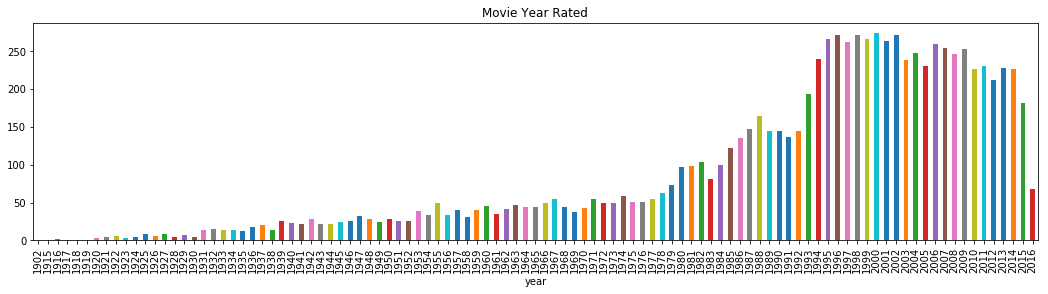

In [152]:
plt.figure(figsize=(18,4))
dfMdTable['Year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('year')
plt.title('Movie Year Rated')
# plt.savefig('rateyear.png')

Text(0.5, 1.0, 'User Movie Ratings')

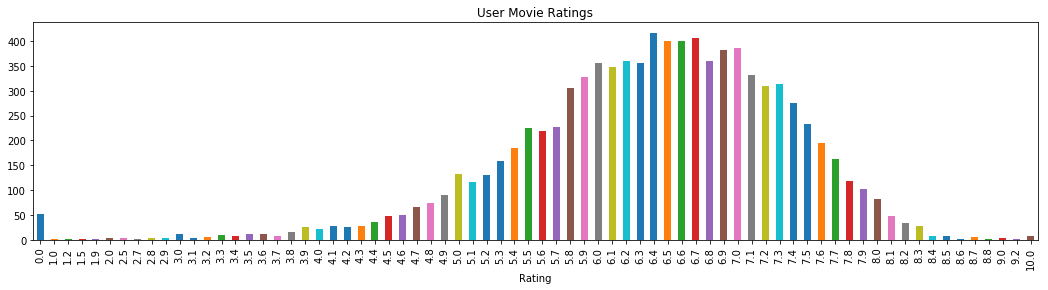

In [153]:
plt.figure(figsize=(18,4))
dfMdTable['Rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.title('User Movie Ratings')
# plt.savefig('ratingsuser.png')

Text(0.5, 1.0, 'Movie Year Distribution')

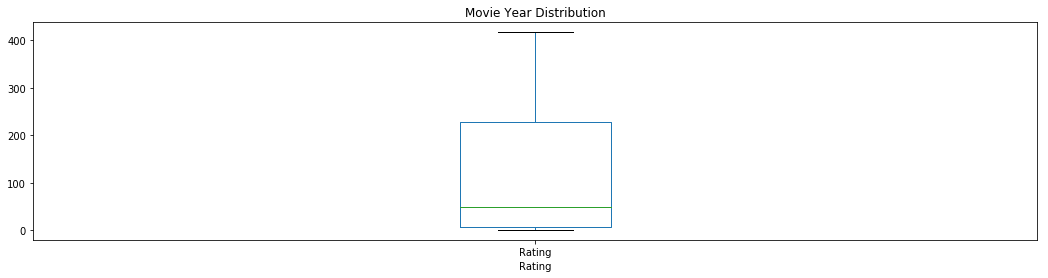

In [154]:
plt.figure(figsize=(18,4))
dfMdTable['Rating'].value_counts().sort_index().plot(kind='box')
plt.xlabel('Rating')
plt.title('Movie Year Distribution')

In [155]:
dfMdTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9100 entries, 0 to 9099
Data columns (total 11 columns):
Title          9100 non-null object
Genres         9100 non-null object
Year           9100 non-null object
Cast           9100 non-null object
Director       9100 non-null object
Rating         9100 non-null float64
RatingCount    9100 non-null float64
Popularity     9100 non-null object
Adult          9100 non-null object
Language       9100 non-null object
Overview       9088 non-null object
dtypes: float64(2), object(9)
memory usage: 782.1+ KB


In [156]:
dfGenre

,adult,id,original_language,overview,popularity,tagline,title,vote_average,vote_count,cast,keywords,director,description,year,genre
0,False,862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995,Animation
0,False,862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995,Comedy
0,False,862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1995,Family
1,False,8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,When siblings Judy and Peter discover an encha...,1995,Adventure
1,False,8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,When siblings Judy and Peter discover an encha...,1995,Fantasy
1,False,8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,When siblings Judy and Peter discover an encha...,1995,Family
2,False,15602,en,A family wedding reignites the ancient feud be...,11.7129,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,A family wedding reignites the ancient feud be...,1995,Romance
2,False,15602,en,A family wedding reignites the ancient feud be...,11.7129,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,A family wedding reignites the ancient feud be...,1995,Comedy
3,False,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.85949,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",Forest Whitaker,"Cheated on, mistreated and stepped on, the wom...",1995,Comedy
3,False,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.85949,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",Forest Whitaker,"Cheated on, mistreated and stepped on, the wom...",1995,Drama


In [157]:
tes = pd.read_csv('id_map.csv')

In [158]:
tes.set_index('title')

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
Heat,6,949.0
Sabrina,7,11860.0
Tom and Huck,8,45325.0
Sudden Death,9,9091.0


In [159]:
tes[tes['id'] == 862][['title','movieId']]

,title,movieId
0,Toy Story,1


In [160]:
id_map[id_map['id'] == 862]['movieId']

title
Toy Story    1
Name: movieId, dtype: int64

In [161]:
dfRating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [162]:
dfRating.movieId.max()

163949

In [163]:
dfRating[dfRating.movieId == 109487]

,userId,movieId,rating,timestamp
2532,15,109487,3.5,1425875392
6863,40,109487,4.5,1466993210
7137,42,109487,4.0,1473258348
7858,48,109487,3.5,1425960344
9398,62,109487,4.5,1451708125
10198,72,109487,3.5,1461778724
11742,73,109487,4.5,1422335272
16192,104,109487,4.5,1446673771
16801,107,109487,4.0,1446493059
20590,138,109487,5.0,1440379056


In [164]:
dfMetadata[dfMetadata.id == 157336]

,level_0,index,adult,genres,id,original_language,overview,popularity,tagline,title,vote_average,vote_count,cast,keywords,director,description,year,keys
8518,8518,23076,False,"[Adventure, Drama, Science Fiction]",157336,en,Interstellar chronicles the adventures of a gr...,32.2135,Mankind was born on Earth. It was never meant ...,Interstellar,8.1,11187.0,"[matthewmcconaughey, jessicachastain, annehath...","[saving the world, artificial intelligence, fa...","[christophernolan, christophernolan, christoph...",Interstellar chronicles the adventures of a gr...,2014,saving the world artificial intelligence fathe...


In [165]:
dfMetadata.id.max()

416437

In [166]:
id_map.movieId.max()

163949

In [167]:
id_map.loc['Interstellar']

movieId    109487.0
id         157336.0
Name: Interstellar, dtype: float64

In [168]:
dfTes = dfMetadata.join(id_map.set_index('id'), on='id')

In [169]:
dfTes.head()

,level_0,index,adult,genres,id,original_language,overview,popularity,tagline,title,vote_average,vote_count,cast,keywords,director,description,year,keys,movieId
0,0,0,False,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.9469,,Toy Story,7.7,5415.0,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy, friendship, friends, riva...","[johnlasseter, johnlasseter, johnlasseter]","Led by Woody, Andy's toys live happily in his ...",1995,jealousy toy boy friendship friends rivalry bo...,1
1,1,1,False,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.0155,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[board game, disappearance, based on children'...","[joejohnston, joejohnston, joejohnston]",When siblings Judy and Peter discover an encha...,1995,board game disappearance based on children's b...,2
2,2,2,False,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[fishing, best friend, duringcreditsstinger, o...","[howarddeutch, howarddeutch, howarddeutch]",A family wedding reignites the ancient feud be...,1995,fishing best friend duringcreditsstinger old m...,3
3,3,3,False,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.85949,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[based on novel, interracial relationship, sin...","[forestwhitaker, forestwhitaker, forestwhitaker]","Cheated on, mistreated and stepped on, the wom...",1995,based on novel interracial relationship single...,4
4,4,4,False,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.38752,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[baby, midlife crisis, confidence, aging, daug...","[charlesshyer, charlesshyer, charlesshyer]",Just when George Banks has recovered from his ...,1995,baby midlife crisis confidence aging daughter ...,5


In [170]:
dfTes = dfTes[['movieId','title','genres','year']]

In [171]:
dfTes

,movieId,title,genres,year
0,1,Toy Story,"[Animation, Comedy, Family]",1995
1,2,Jumanji,"[Adventure, Fantasy, Family]",1995
2,3,Grumpier Old Men,"[Romance, Comedy]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
5,6,Heat,"[Action, Crime, Drama, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995
7,8,Tom and Huck,"[Action, Adventure, Drama, Family]",1995
8,9,Sudden Death,"[Action, Adventure, Thriller]",1995
9,10,GoldenEye,"[Adventure, Action, Thriller]",1995


In [172]:
id_map[id_map.id == 862]

,movieId,id
title,,
Toy Story,1,862.0


In [173]:
dfRating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [174]:
dfGabungRate = dfRating.join(dfTes.set_index('movieId'), on='movieId')

In [175]:
dfGabungRate.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,31,2.5,1260759144,Dangerous Minds,"[Drama, Crime]",1995
1,1,1029,3.0,1260759179,Dumbo,"[Animation, Family]",1941
2,1,1061,3.0,1260759182,Sleepers,"[Crime, Drama, Thriller]",1996
3,1,1129,2.0,1260759185,Escape from New York,"[Science Fiction, Action]",1981
4,1,1172,4.0,1260759205,Cinema Paradiso,"[Drama, Romance]",1988


In [176]:
dfGabungRate.columns = ('userId', 'movieId','Rating','Timestamp','Title','Genres','Year')

In [177]:
dfGabungRate.head()

,userId,movieId,Rating,Timestamp,Title,Genres,Year
0,1,31,2.5,1260759144,Dangerous Minds,"[Drama, Crime]",1995
1,1,1029,3.0,1260759179,Dumbo,"[Animation, Family]",1941
2,1,1061,3.0,1260759182,Sleepers,"[Crime, Drama, Thriller]",1996
3,1,1129,2.0,1260759185,Escape from New York,"[Science Fiction, Action]",1981
4,1,1172,4.0,1260759205,Cinema Paradiso,"[Drama, Romance]",1988


In [178]:
dfGabungRate['Timestamp'] = dfGabungRate['Timestamp'].apply(lambda x : pd.Timestamp(x, unit='s'))

In [179]:
dfGabungRate.head()

,userId,movieId,Rating,Timestamp,Title,Genres,Year
0,1,31,2.5,2009-12-14 02:52:24,Dangerous Minds,"[Drama, Crime]",1995
1,1,1029,3.0,2009-12-14 02:52:59,Dumbo,"[Animation, Family]",1941
2,1,1061,3.0,2009-12-14 02:53:02,Sleepers,"[Crime, Drama, Thriller]",1996
3,1,1129,2.0,2009-12-14 02:53:05,Escape from New York,"[Science Fiction, Action]",1981
4,1,1172,4.0,2009-12-14 02:53:25,Cinema Paradiso,"[Drama, Romance]",1988


In [180]:
dfGabungRate = dfGabungRate[['userId','movieId','Title','Rating','Year','Genres','Timestamp']]

In [181]:
dfGabungRate[dfGabungRate['userId'] == 1]

,userId,movieId,Title,Rating,Year,Genres,Timestamp
0,1,31,Dangerous Minds,2.5,1995,"[Drama, Crime]",2009-12-14 02:52:24
1,1,1029,Dumbo,3.0,1941,"[Animation, Family]",2009-12-14 02:52:59
2,1,1061,Sleepers,3.0,1996,"[Crime, Drama, Thriller]",2009-12-14 02:53:02
3,1,1129,Escape from New York,2.0,1981,"[Science Fiction, Action]",2009-12-14 02:53:05
4,1,1172,Cinema Paradiso,4.0,1988,"[Drama, Romance]",2009-12-14 02:53:25
5,1,1263,The Deer Hunter,2.0,1978,"[Drama, War]",2009-12-14 02:52:31
6,1,1287,Ben-Hur,2.0,1959,"[Action, Adventure, Drama, History]",2009-12-14 02:53:07
7,1,1293,Gandhi,2.0,1982,"[Drama, History]",2009-12-14 02:52:28
8,1,1339,Dracula,3.5,1992,"[Romance, Horror]",2009-12-14 02:52:05
9,1,1343,Cape Fear,2.0,1991,"[Crime, Thriller]",2009-12-14 02:52:11


In [ ]:
pd.Timestamp(1063502716, unit='s')

In [ ]:
import time
time.ctime(1063502716)

In [ ]:
dfGabungRate.to_csv("dfUserRating.csv", encoding='utf-8', index=False)

In [ ]:
dfGabungRate.info()